# DeepAR usage example

Firstly, let's prepare some data

In [3]:
# for in-project run - uncomment
# 
# 
# import os
# os.chdir('../../../../..')

Assert M4 datasets are placed as follows:

PROJECT_PATH/examples/data/ts

In [4]:
import random
from pathlib import Path

import pandas as pd
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from sklearn.metrics import f1_score, roc_auc_score
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot_ind.core.architecture.settings.computational import backend_methods as np

import matplotlib

from fedot_ind.core.architecture.settings.computational import backend_methods as np
from fedot.core.composer.metrics import smape
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline_builder import PipelineBuilder

from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
import matplotlib.pyplot as plt

matplotlib.use('TkAgg')

ts_datasets = {
    'm4_yearly': Path(PROJECT_PATH, 'examples', 'data', 'ts', 'M4Yearly.csv'),
    'm4_weekly': Path(PROJECT_PATH, 'examples', 'data', 'ts', 'M4Weekly.csv'),
    'm4_daily': Path(PROJECT_PATH, 'examples', 'data', 'ts', 'M4Daily.csv'),
    'm4_monthly': Path(PROJECT_PATH, 'examples', 'data', 'ts', 'M4Monthly.csv'),
    'm4_quarterly': Path(PROJECT_PATH, 'examples', 'data', 'ts', 'M4Quarterly.csv')}


def evaluate_metric(target, prediction):
    try:
        if len(np.unique(target)) > 2:
            metric = f1_score(target, prediction, average='weighted')
        else:
            metric = roc_auc_score(target, prediction, average='weighted')
    except Exception:
        metric = f1_score(target, np.argmax(prediction, axis=1), average='weighted')
    return metric


def get_ts_data(dataset='m4_monthly', horizon: int = 30, m4_id=None):
    time_series = pd.read_csv(ts_datasets[dataset])

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=horizon))
    if not m4_id:
        label = random.choice(np.unique(time_series['label']))
    else:
        label = m4_id
    print(label)
    time_series = time_series[time_series['label'] == label]

    if 'datetime' in time_series.columns:
        idx = pd.to_datetime(time_series['datetime'].values)
    else:
        # non datetime indexes
        idx = time_series['idx'].values

    time_series = time_series['value'].values
    train_input = InputData(idx=idx,
                            features=time_series,
                            target=time_series,
                            task=task,
                            data_type=DataTypesEnum.ts)
    train_data, test_data = train_test_data_setup(train_input)
    return train_data, test_data, label


def plot_metrics_and_prediction(test_data: InputData,
                                train_data: InputData,
                                model_prediction: np.array,
                                baseline_prediction: np.array,
                                model_name,
                                dataset_name):
    plt.title(dataset_name)
    plt.plot(train_data.idx, test_data.features, label='features')
    plt.plot(test_data.idx, test_data.target, label='target')
    plt.plot(test_data.idx, model_prediction, label=model_name)
    plt.plot(test_data.idx, baseline_prediction, label='predicted baseline')
    plt.grid()
    plt.legend()
    plt.show()

    print(f"model smape: {smape(test_data.target, model_prediction)}")
    print(f"baseline smape: {smape(test_data.target, baseline_prediction)}")


FORECAST_LENGTH = 32


## DeepAR atomized

DeepAR launch as a standalone model

some modifications with input_data have to be done

In [11]:
train_data, test_data, dataset_name = get_ts_data('m4_monthly', FORECAST_LENGTH)
train_data.idx = np.arange(train_data.features.shape[0]) # index must be numerical
lidx = train_data.idx[-1]
test_data.idx = np.arange(lidx + 1, lidx + 1 + test_data.target.shape[0] )

print('train_data shape', 'features:', train_data.features.shape, 'target:', train_data.target.shape)


M36886
train_data shape features: (160,) target: (160,)


In [12]:
import torch
from importlib import reload
import fedot_ind.core.models.nn.network_impl.deepar as DP 
reload(DP)


deepar = DP.DeepAR({'forecast_length': 11, 'patch_len': 13,'epochs': 25, 'batch_size': 8, 'cell_type': 'LSTM', 
                    'print_training_progress': True, 'quantiles': [0.05, 0.95]})
train_loader, val_loader = deepar._prepare_data(train_data, split_data=False, horizon=1)

print('size of train_batch X: ', next(iter(deepar._prepare_data(train_data, split_data=False, horizon=1)[0]))[0].shape)
print('size of  train_batch y: ', next(iter(deepar._prepare_data(train_data, split_data=False, horizon=1)[0]))[1].shape)
print('size of test_batch X: ', next(iter(deepar._prepare_data(test_data, split_data=False, horizon=1, is_train=False)[0]))[0].shape)
print('size of  test_batch y: ', next(iter(deepar._prepare_data(test_data, split_data=False, horizon=1, is_train=False)[0]))[1].shape)

size of train_batch X:  torch.Size([8, 1, 13])
size of  train_batch y:  torch.Size([8, 1])
size of test_batch X:  torch.Size([11, 1, 13])
size of  test_batch y:  torch.Size([11, 1])


In [13]:
deepar.fit(train_data)
md = deepar.model

Total epochs: 100
Epoch: 1, Steps: 19 | Train Loss: 378.7452286
Updating learning rate to 0.004263873235634277
Epoch: 2, Steps: 19 | Train Loss: 264.8557507
Updating learning rate to 0.005052591730683592
Epoch: 3, Steps: 19 | Train Loss: 137.4235394
Updating learning rate to 0.006357483747594067
Epoch: 4, Steps: 19 | Train Loss: 49.8511922
Updating learning rate to 0.008164202366421722
Epoch: 5, Steps: 19 | Train Loss: 22.1164032
Updating learning rate to 0.010452883225173598
Epoch: 6, Steps: 19 | Train Loss: 14.4995433
Updating learning rate to 0.013198362922869175
Epoch: 7, Steps: 19 | Train Loss: 11.6912079
Updating learning rate to 0.016370455684041788
Epoch: 8, Steps: 19 | Train Loss: 10.1906199
Updating learning rate to 0.019934285242832195
Epoch: 9, Steps: 19 | Train Loss: 9.2825859
Updating learning rate to 0.023850668297701744
Epoch: 10, Steps: 19 | Train Loss: 8.5823137
Updating learning rate to 0.028076545320789112
Epoch: 11, Steps: 19 | Train Loss: 8.0108510
Updating learni

In [73]:
predictions = deepar.predict(test_data).predict
raws = deepar.predict(test_data, 'raw').predict
quantiles = deepar.predict(test_data, 'quantiles').predict

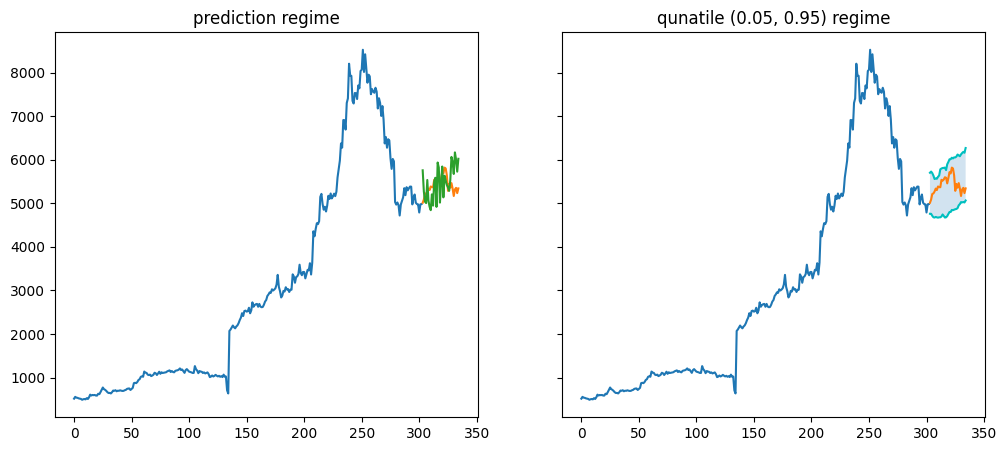

In [70]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(12)
axes[0].plot(train_data.idx, train_data.target, label='train_data')
axes[0].plot(test_data.idx, test_data.target, label='test_data')
axes[0].plot(test_data.idx, predictions, label='sample_prediction')
axes[0].set_title(dataset_name, 'prediction regime')

axes[1].plot(train_data.idx, train_data.target, label='train_data')
axes[1].plot(test_data.idx, test_data.target, label='test_data')
axes[1].plot(test_data.idx, quantiles[:, 0], c='c')
axes[1].plot(test_data.idx, quantiles[:, -1], c='c')
axes[1].fill_between(test_data.idx, quantiles[:, 0], quantiles[:, -1], alpha=0.2)
axes[1].set_title(dataset_name, 'quantile (0.05, 0.95) regime');


## API launch

In [2]:
train_data, test_data, dataset_name = get_ts_data('m4_monthly', FORECAST_LENGTH)

M11010


In [3]:
model_dict = {'deepar_model': PipelineBuilder().add_node('deepar_model', params={'use_collate_fn': True}),
              'baseline': PipelineBuilder().add_node('ar')
              }
baseline = model_dict['baseline'].build()
del model_dict['baseline']
baseline.fit(train_data)
baseline_prediction = np.ravel(baseline.predict(test_data).predict)

In [4]:
with IndustrialModels():
        for model in model_dict.keys():
            repo = IndustrialModels().setup_repository()
            pipeline = model_dict[model].build()
            pipeline.fit(train_data)
            model_prediction = pipeline.predict(test_data).predict


2024-06-03 22:54:05,323 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-03 22:54:05,428 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-03 22:54:05,446 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-03 22:54:05,446 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-03 22:54:05,463 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

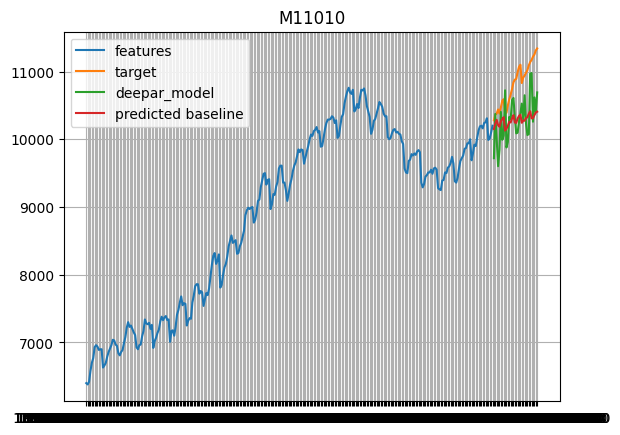

model smape: 5.092084044120939
baseline smape: 4.880613378216021


In [5]:
%matplotlib inline
with IndustrialModels():
    plot_metrics_and_prediction(test_data,
                                        train_data,
                                        model_prediction,
                                        baseline_prediction,
                                        model,
                                        dataset_name)
    _ = 1

## Composition trials


In [5]:
train_data, test_data, dataset_name = get_ts_data('m4_monthly', FORECAST_LENGTH)

M34536


In [47]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import AbstractPipeline
from fedot_ind.core.metrics.metrics_implementation import RMSE


BENCHMARK = r'examples\data\forecasting'
TASK = 'ts_forecasting'
TASK_PARAMS = {'forecast_length': FORECAST_LENGTH}
DATASET_NAME = 'M19553'

PIPELINES = {
        'composite_deepar1': {
            0: ['eigen_basis'],
             1: ['wavelet_basis', 'smoothing'],
             2: [None],
            'head': 'deepar_model'},
        'composite_deepar2': {
            0: ['smoothing'],
             1: ['eigen_basis'], 
              'head': 'deepar_model'}
}


def run_composite(nodes, train_data, test_data):
        ap = AbstractPipeline(task=TASK, task_params=TASK_PARAMS)
        p = ap.create_pipeline(nodes)
        p.fit(train_data)
        predict = p.predict(test_data).predict
        target = test_data.features[-ap.task_params['forecast_length']:].flatten()
        metric = ap.base_metric(target, predict, predict).metric()

        return dict(fitted_model=ap,
                    forecast=predict,
                    target=target,
                    quality_metric=metric
                    )



In [48]:
with IndustrialModels():
    repo = IndustrialModels().setup_repository() 
    results = {
        name: run_composite(pipeline, train_data, test_data) for name, pipeline in PIPELINES.items()
    }

In [51]:
%matplotlib inline
def plot_composite_results(results):
    def plot_composite_results(res: dict, ax, name):
        ax.plot(res['forecast'], label='forecast')
        ax.plot(res['target'], label='target')
        ax.set_title("RMSE: " + str(np.round(res['quality_metric'])))
        ax.legend()
    
    fig, axes = plt.subplots(1, len(results))
    fig.set_figheight(5)
    fig.set_figwidth(12)
    for ax, res in zip(axes, results):
        plot_composite_results(results[res], ax, res)
    

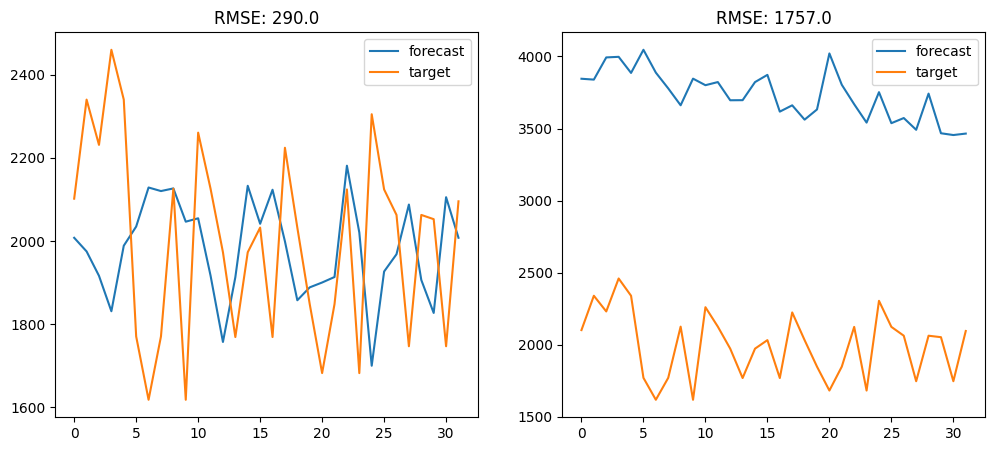

In [52]:
plot_composite_results(results)